In [1]:
import gpmultipy, scipy, json
import numpy as np
import matplotlib.pyplot as plt
from copy import copy

In [2]:
from gpmultipy import dataset
from gpmultipy.model import Model
from gpmultipy.prior import Prior
from gpmultipy.kernel import RBF, White
from gpmultipy.freeze import Freezer
from gpmultipy.sampler.slice import Slice
from gpmultipy.kernel import Product, Linear, Addition, Bias

In [3]:
def printSample(sample,depth=1):
    keys = sample.keys()
    keys.sort()
    
    for k in keys:
        if type(sample[k]) == dict:
            print "\t".join([""]*depth) + k
            printSample(sample[k],depth=depth+1)
        else:
            print "\t".join([""]*depth) + "%s: %s"%(k,str(sample[k]))

In [4]:
%matplotlib inline

In [49]:
ds = dataset.DataSet('data/')
x,y,effect,labels = ds.build(Strain='ura3',mM_PQ=0.0,scale='range',Bio='E')
y = (y-y.mean())/y.std()

# x = x + 1e-3

$K(x,y) = \Big(\sigma^2_{bias} + \sigma^2_{linear} \cdot xy^T \Big) \times K_{RBF}(x,y)$

In [92]:
yKernel = White(1,.1)
k1 = RBF(1,1,1)
# k2 = Product(Linear(1,1,1),RBF(1,1,1))
k2 = Product(Addition(Bias(1,1e-3),Linear(1,1,1)),RBF(1,5,.5))

p = y.shape[1]
dm = np.zeros((1+p,p))
dm[0,:] = 1
# dm[1:,1:] = 1
np.fill_diagonal(dm[1:,:],1)

prior = Prior(x,k1,[0])
prior2 = Prior(x,k2,range(1,dm.shape[0]))

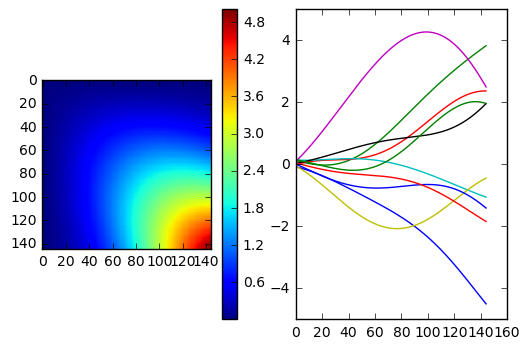

In [93]:
cov = k2.K(x)

plt.subplot(121)
plt.imshow(cov,interpolation='none')
plt.colorbar()

plt.subplot(122)
plt.plot(scipy.stats.multivariate_normal.rvs(prior2.mu,cov,size=10).T);

In [52]:
model = Model(x,y,dm)

In [53]:
ySigmaSlice = Slice('ySigma',
                    lambda x: model.dataLikelihood(yKernel,sigma=x),
                    lambda x: scipy.stats.lognorm(1,scale=1e-0).logpdf(x),
                    .2,5,logspace=True)

kSigmaSlice = Slice('kSigma',
                    lambda x: prior.loglikelihood(model.beta,sigma=x),
                    lambda x: scipy.stats.uniform(1e-2,1e2).logpdf(x),
                    .2,5,logspace=True)

kLengthscaleSlice = Slice('kLengthscale',
                    lambda x: prior.loglikelihood(model.beta,lengthscale=x),
                    lambda x: scipy.stats.uniform(1e-2,1e2).logpdf(x),
                    .2,5,logspace=True)

k2k1k1SigmaSlice = Slice('kSigma',
                    lambda x: prior2.loglikelihood(model.beta,k1_k1_sigma=x),
                    lambda x: scipy.stats.uniform(1e-2,1e2).logpdf(x),
                    .2,5,logspace=True)

k2k1k2SigmaSlice = Slice('kSigma',
                    lambda x: prior2.loglikelihood(model.beta,k1_k2_sigma=x),
                    lambda x: scipy.stats.uniform(1e-2,1e2).logpdf(x),
                    .2,5,logspace=True)

k2k1k2LengthscaleSlice = Slice('kLengthscale',
                    lambda x: prior2.loglikelihood(model.beta,k1_k2_lengthscale=x),
                    lambda x: scipy.stats.uniform(1e-2,1e2).logpdf(x),
                    .2,5,logspace=True)

k2k2SigmaSlice = Slice('kSigma',
                    lambda x: prior2.loglikelihood(model.beta,k2_sigma=x),
                    lambda x: scipy.stats.uniform(1e-2,1e2).logpdf(x),
                    .2,5,logspace=True)

k2k2LengthscaleSlice = Slice('kLengthscale',
                    lambda x: prior2.loglikelihood(model.beta,k2_lengthscale=x),
                    lambda x: scipy.stats.uniform(1e-2,1e2).logpdf(x),
                    .2,5,logspace=True)

samples = []
freeze = Freezer(yKernel=yKernel,k1=k1,k2=k2,model=model)

In [54]:
thin = 10
burnin = 0
nsample = 1000

for i in range(nsample):
    prior.sample(model,yKernel)
    prior2.sample(model,yKernel)
    
    yKernel.sigma = ySigmaSlice.sample(yKernel.sigma)
    
    k1.sigma = kSigmaSlice.sample(k1.sigma)
    k1.lengthscale = kLengthscaleSlice.sample(k1.lengthscale)
    
    k2.k1.k1.sigma = k2k1k1SigmaSlice.sample(k2.k1.k1.sigma)
    k2.k1.k2.sigma = k2k1k2SigmaSlice.sample(k2.k1.k2.sigma)
    #k2.k1.k2.lengthscale = k2k1k2LengthscaleSlice.sample(k2.k1.k2.lengthscale)
    
    #k2.k2.sigma = k2k2SigmaSlice.sample(k2.k2.sigma)
    k2.k2.lengthscale = k2k2LengthscaleSlice.sample(k2.k2.lengthscale)

    if i % thin == 0 and i > burnin:
        #print model.dataLikelihood(yKernel),yKernel.sigma, k1.sigma, k1.lengthscale, k2.k1.k1.sigma, k2.k1.k2.sigma, k2.k1.k2.lengthscale, k2.k2.sigma, k2.k2.lengthscale
        f = freeze.freeze()
        del f['model']
        
        print "~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~"
        print model.dataLikelihood(yKernel)
        printSample(f)
        print
        
        samples.append(freeze.freeze())

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2962.85908283
k1
	lengthscale: 0.0707969712576
	sigma: 0.458665634943
k2
	k1
		k1
			sigma: 0.111587280059
		k2
			lengthscale: 1
			sigma: 0.916709746407
	k2
		lengthscale: 0.0712805535125
		sigma: 1
yKernel
	sigma: 0.000982629099645

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2988.83392476
k1
	lengthscale: 0.0741018100291
	sigma: 0.288449180686
k2
	k1
		k1
			sigma: 0.110895492228
		k2
			lengthscale: 1
			sigma: 0.380039982891
	k2
		lengthscale: 0.0725138017088
		sigma: 1
yKernel
	sigma: 0.00099198914986

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2972.08427701
k1
	lengthscale: 0.0754563614341
	sigma: 0.155998732498
k2
	k1
		k1
			sigma: 0.0835396825051
		k2
			lengthscale: 1
			sigma: 0.250985889407
	k2
		lengthscale: 0.0768106586644
		sigma: 1
yKernel
	sigma: 0.000964731599185

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2927.8405366
k1
	lengthscale: 0.0783913120365
	sigma: 0.120050079496
k2
	k1
		k1
			sigma: 0.0945480117635
		k2
			lengthscale: 1
		

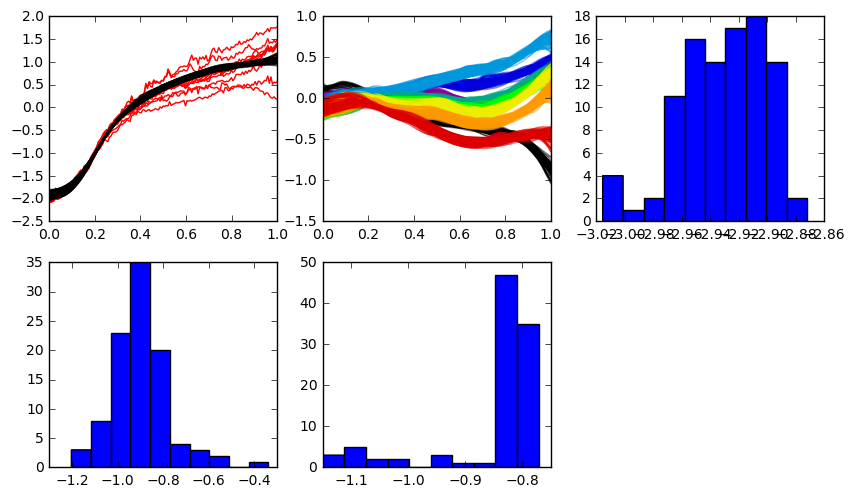

In [55]:
plt.figure(figsize=(10,9))
plt.subplot(331)
plt.plot(x,y,c='r')

# plt.subplot(232)
plt.plot(x,np.array([s['model']['beta'][:,0] for s in samples]).T,c='k',alpha=.5)

plt.subplot(332)

cmap = plt.get_cmap("spectral")
colors = [cmap(1.*i/p) for i in range(p)]
for i in range(p):
    plt.plot(x,np.array([s['model']['beta'][:,i+1] for s in samples]).T,c=colors[i],alpha=.5)

plt.subplot(333)
plt.hist(np.log10([s['yKernel']['sigma'] for s in samples]))

plt.subplot(334)
plt.hist(np.log10([s['k1']['sigma'] for s in samples]))

plt.subplot(335)
plt.hist(np.log10([s['k1']['lengthscale'] for s in samples]))

# plt.subplot(336)
# plt.hist(np.log10([s['k2']['k1']['sigma'] for s in samples]))

# plt.subplot(337)
# plt.hist(np.log10([s['k2']['k1']['lengthscale'] for s in samples]))

# plt.subplot(338)
# plt.hist(np.log10([s['k2']['k2']['sigma'] for s in samples]))

# plt.subplot(339)
# plt.hist(np.log10([s['k2']['k2']['lengthscale'] for s in samples]))

plt.savefig("figures/randomEffect-linearXrbf-samples.pdf",bbox_inches='tight')

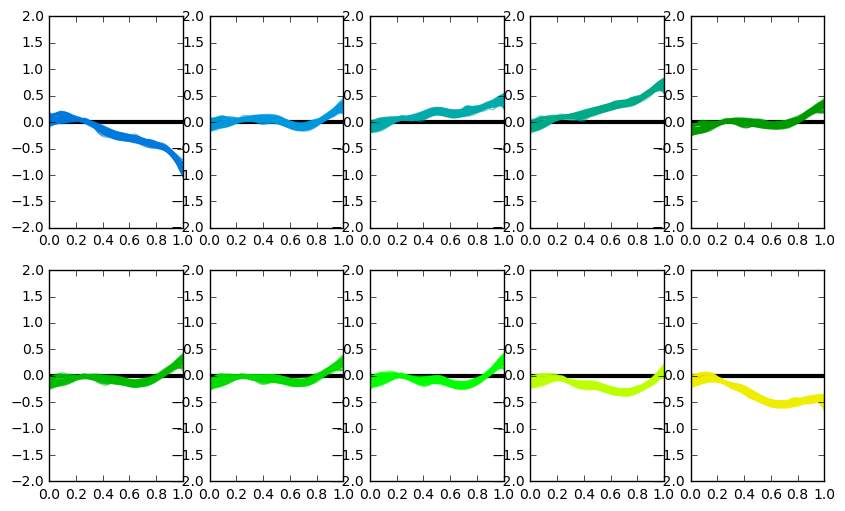

In [56]:
plt.figure(figsize=(10,6))

ncol = 5

cmap = plt.get_cmap("spectral")
colors = [cmap(1.*(i+5)/(p+10)) for i in range(p)]

for i in range(p):
    plt.subplot(p/ncol,ncol,i+1)
    
    plt.plot([x.min(),x.max()],[0,0],c='k',lw=3)
    plt.plot(x,np.array([s['model']['beta'][:,i+1] for s in samples[0:]]).T,c=colors[i],alpha=.5)
    
    plt.ylim(-2,2)

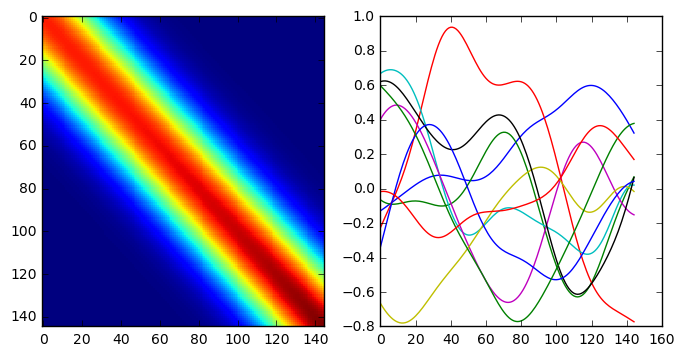

In [57]:
cov = k2.K(x)

plt.figure(figsize=(8,4))

plt.subplot(121)
plt.imshow(cov,interpolation='none',aspect='auto')
# plt.colorbar()

plt.subplot(122)
plt.plot(scipy.stats.multivariate_normal.rvs(prior2.mu,cov,size=10).T);

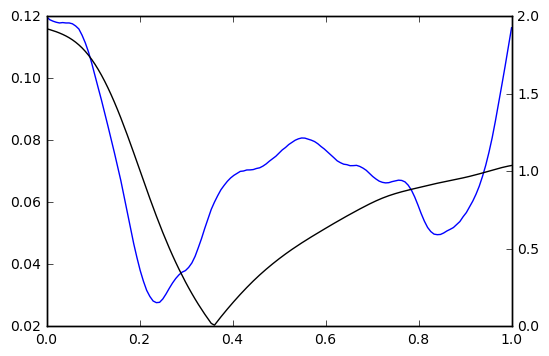

In [65]:
mu = np.array([s['model']['beta'][:,0] for s in samples]).T

plt.plot(x,mu.std(1)*2);

plt.twinx()
plt.plot(x,abs(mu.mean(1)),c='k');

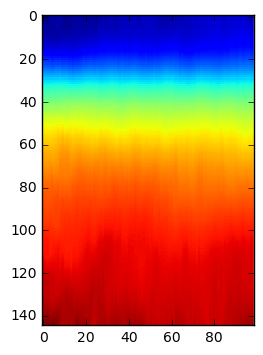

In [66]:
plt.imshow(mu,interpolation='none')

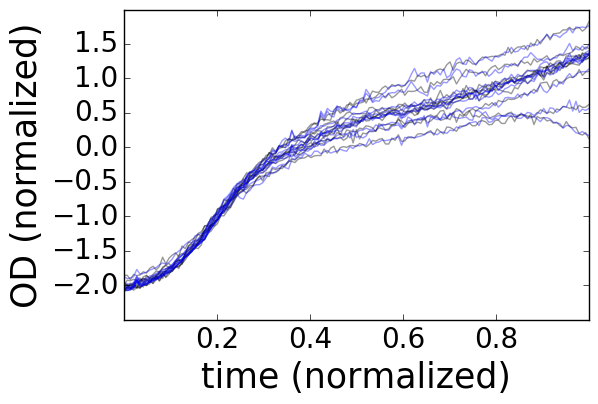

In [59]:
plt.figure(figsize=(6,4))

beta = samples[-1]['model']['beta']
mu = np.dot(beta,model.designMatrix).T
cov = yKernel.K(x)
ysample = mu + scipy.stats.multivariate_normal.rvs(np.zeros(x.shape[0]),cov,size=model.r)

plt.plot(x[:,0],ysample.T,c='k',alpha=.4); 
plt.plot(x[:,0],y,c='b',alpha=.4); 
# plt.plot(x[:,0],fsample,c='r',lw=3);

plt.xlabel("time (normalized)",fontsize=25)
plt.ylabel("OD (normalized)",fontsize=25)
plt.xticks(np.arange(.2,1,.2),fontsize=20)
plt.yticks(np.arange(-2,2,.5),fontsize=20)

plt.savefig("figures/model-randomEffect-linearXrbf-generative-sameBeta.pdf",bbox_inches='tight',dpi=300)

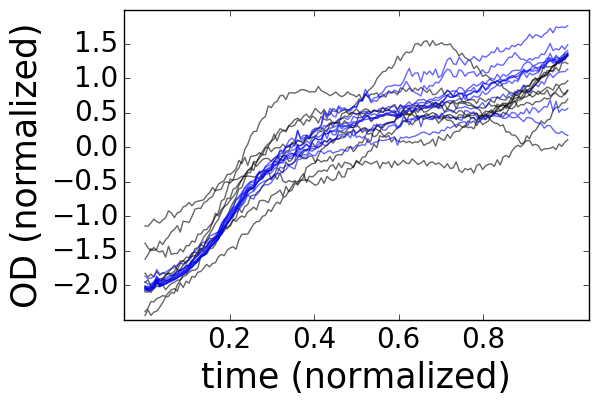

In [60]:
plt.figure(figsize=(6,4))

beta = samples[-1]['model']['beta']
cov = k2.K(x)
chol = gpmultipy.linalg.jitchol(cov)
cov = np.dot(chol,chol.T)

for i in range(1,beta.shape[1]):
    beta[:,i] = scipy.stats.multivariate_normal.rvs(prior2.mu,cov)

mu = np.dot(beta,model.designMatrix).T
cov = yKernel.K(x)
ysample = mu + scipy.stats.multivariate_normal.rvs(np.zeros(x.shape[0]),cov,size=model.r)

plt.plot(x[:,0],ysample.T,c='k',alpha=.6); 
plt.plot(x[:,0],y,c='b',alpha=.6); 
# plt.plot(x[:,0],fsample,c='r',lw=3);

plt.xlabel("time (normalized)",fontsize=25)
plt.ylabel("OD (normalized)",fontsize=25)
plt.xticks(np.arange(.2,1,.2),fontsize=20)
plt.yticks(np.arange(-2,2,.5),fontsize=20)
plt.xlim(x.min()-x.max()*.05,x.max()*1.05)

plt.savefig("figures/model-randomEffect-linearXrbf-generative-newBeta.pdf",bbox_inches='tight',dpi=300)

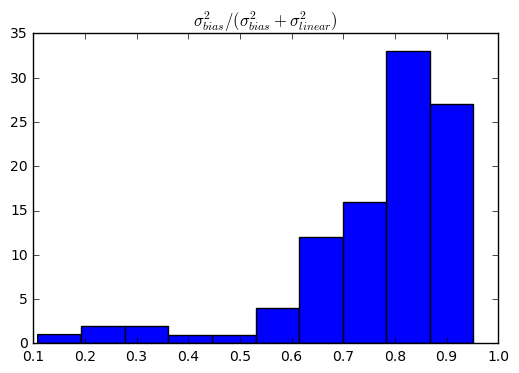

In [67]:
ratio = [1.*s['k2']['k1']['k1']['sigma']/(s['k2']['k1']['k1']['sigma'] + s['k2']['k1']['k2']['sigma']) for s in samples]

plt.hist(ratio)
plt.title("$\sigma^2_{bias} / (\sigma^2_{bias} + \sigma^2_{linear})$")

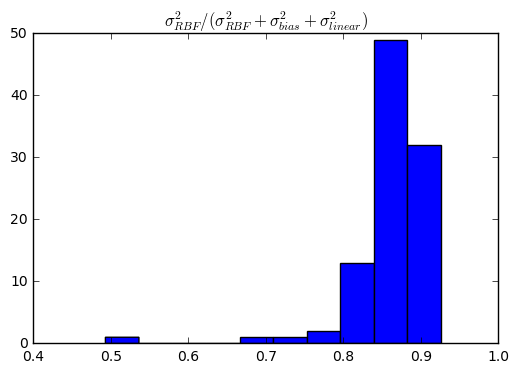

In [68]:
ratio = [1.*s['k2']['k2']['sigma']/(s['k2']['k2']['sigma']+ s['k2']['k1']['k1']['sigma'] + s['k2']['k1']['k2']['sigma']) for s in samples]

plt.hist(ratio)
plt.title("$\sigma^2_{RBF} / (\sigma^2_{RBF} + \sigma^2_{bias} + \sigma^2_{linear})$")

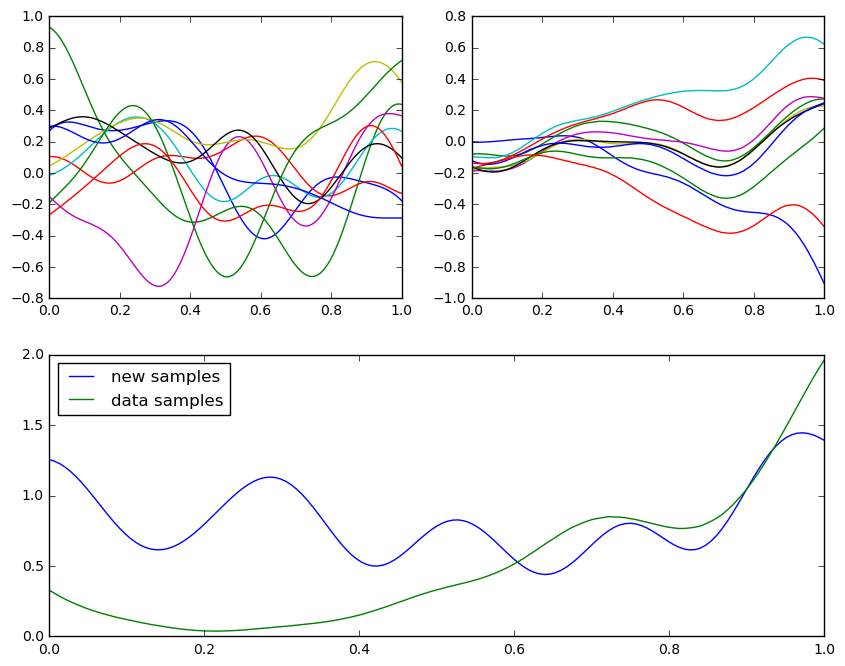

In [77]:
cov = k2.K(x)

plt.figure(figsize=(10,8))

plt.subplot2grid((2,2),(0,0))
sample = scipy.stats.multivariate_normal.rvs(prior2.mu,cov,size=10)

plt.plot(x,sample.T);
plt.xlim(x.min(),x.max())

plt.subplot2grid((2,2),(0,1))
beta = np.array(samples[-2]['model']['beta'][:,1:])
plt.plot(x,beta)

plt.subplot2grid((2,2),(1,0),colspan=2)

plt.plot(x,np.sum(sample.T*sample.T,1),label='new samples');
plt.plot(x,np.sum(model.beta[:,1:]*model.beta[:,1:],1),label='data samples');
plt.xlim(x.min(),x.max())
plt.legend(loc='best')

In [72]:
beta = np.array(samples[-2]['model']['beta'][:,1:])


In [94]:
samplesCopy = [copy(s) for s in samples]
for s in samplesCopy:
    s['model']['beta'] = s['model']['beta'].tolist()

NameError: name 'copy' is not defined

In [91]:
s = json.dumps(samplesCopy)

In [92]:
ofile = open("technical-replicate-linearRBF.json",'w')
ofile.write(s)
ofile.close()